In [43]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Load Data

In [44]:
#from google.colab import drive
#drive.mount('/content/drive')

In [45]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('Data/stores.csv')
df_items = pd.read_csv('Data/items.csv')
df_transactions = pd.read_csv('Data/transactions.csv')
df_oil = pd.read_csv('Data/oil.csv')

# Featured Holiday_events
df_holidays_events = pd.read_csv('Data/holidays_events_processed.csv')

# Filtered train
df_train = pd.read_csv('Data/train_Guayas.csv')

/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_2501/2325352464.py:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('Data/train_Guayas.csv')


# Data Preprocessing


## Handling Missing Values

This section addresses missing data in the training and oil price datasets.

In [53]:
df_train.isnull().sum()

id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

### The onpromotion column contains many missing values (NaN).

Since promotions are rare, missing values are assumed to mean no promotion. These missing values are replaced with False, then the column is converted to a binary integer (0/1).

In [54]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)
df_train['onpromotion'] = df_train['onpromotion'].astype('int64')
df_train.isnull().sum()

id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

In [51]:
df_train['onpromotion'].value_counts()

onpromotion
0    14066471
1      679297
Name: count, dtype: int64

In [52]:
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

#### Visualize the oil prices with missing values

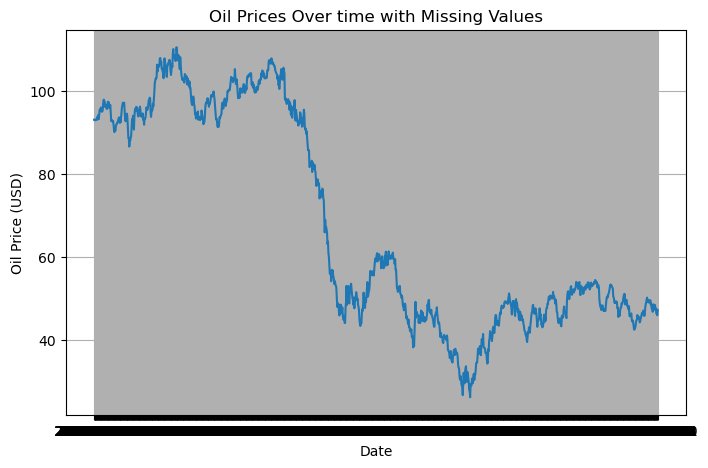

In [55]:
plt.figure(figsize=(8,5))
plt.plot(df_oil['date'], df_oil['dcoilwtico'])
plt.title('Oil Prices Over time with Missing Values')
plt.xlabel('Date')
plt.ylabel('Oil Price (USD)')
plt.grid(True)
plt.show()

### The dcoilwtico column has missing values which are filled using linear interpolation.

This method is suitable because oil prices typically change smoothly over time. Interpolation ensures no gaps remain without introducing bias from forward or backward filling alone.

In [50]:
# Filling null value using linear interpolation  method for oil price in oil dataset
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear', limit_direction='both')
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

### Visualize the oil prices after missing value imputation are plotted to verify the effectiveness of the interpolation.

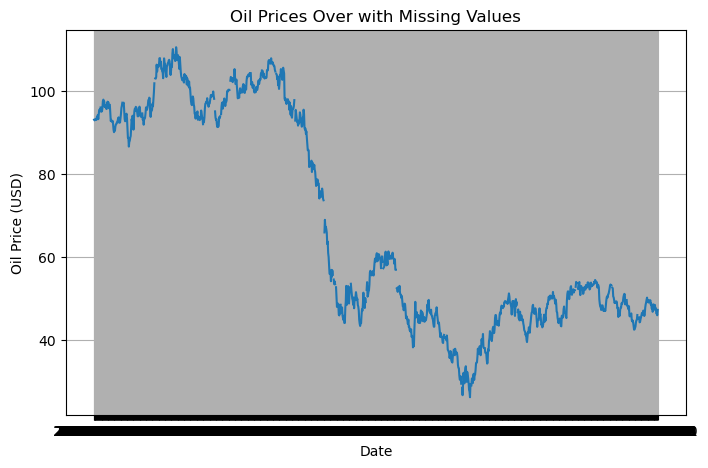

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(df_oil['date'], df_oil['dcoilwtico'])
plt.title('Oil Prices Over time with Missing Values')
plt.xlabel('Date')
plt.ylabel('Oil Price (USD)')
plt.grid(True)
plt.show()

Now we can see how oil price changes over time after we handle missing values.

## Handling Negative Sales and Outliers

#### Negative Sales Handling

Negative sales values in unit_sales likely represent product returns. These are replaced with zero to reflect no sales rather than negative quantities.

In [56]:
# Check negative sales from store
negative_sales = df_train[df_train['unit_sales'] < 0]
print('Total negative sale',len(negative_sales))
negative_sales.head()

Total negative sale 794


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
13289,106658,2013-01-04,34,586824,-2.0,0
38690,309805,2013-01-09,35,1079215,-8.0,0
45715,382905,2013-01-11,27,1097187,-20.0,0
68451,564108,2013-01-15,51,627885,-36.0,0
94237,787522,2013-01-21,24,211205,-5.0,0


In [57]:
# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: 0 if x < 0 else x)
df_train[df_train['unit_sales'] < 0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion


In [58]:
print('Unique store number',df_train['store_nbr'].nunique())
print('Uniques items number',df_train['item_nbr'].nunique())

Unique store number 11
Uniques items number 2323


#### Visualize total unit sales across all years

Aggregate total unit sales by date and plot the trend to visualize sales over time.

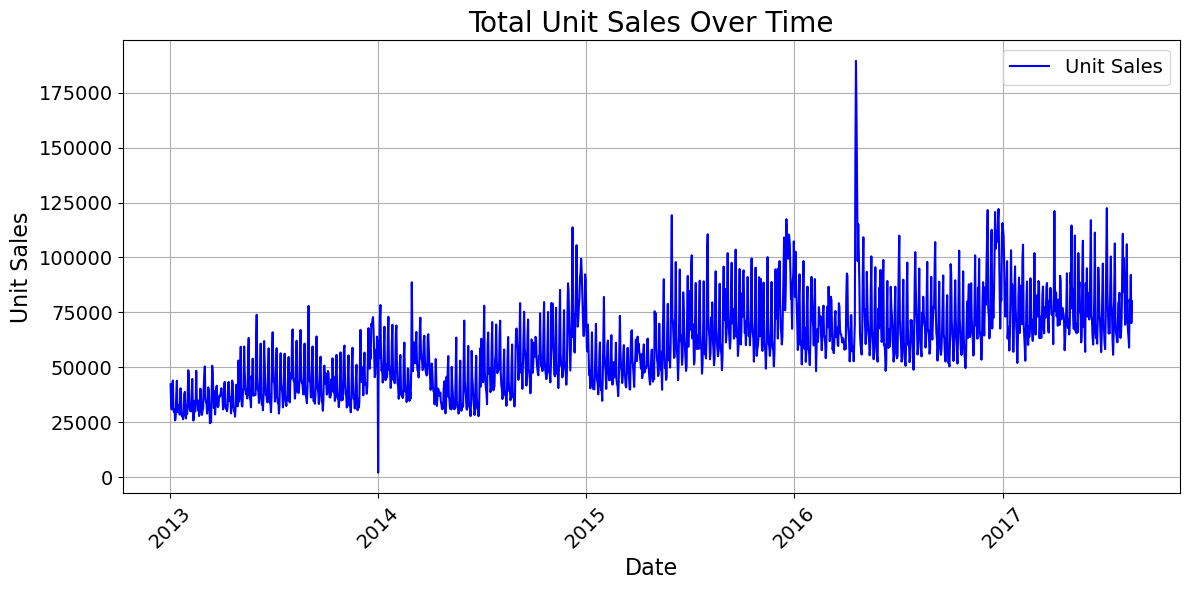

In [59]:
# Total unit_sales by date
df_train_= df_train.copy()
df_train_['date'] = pd.to_datetime(df_train_['date'])
sales_by_date = df_train_.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date.index, sales_by_date.values, label='Unit Sales', color='blue')
plt.title('Total Unit Sales Over Time', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

### Outlier Detection


Extreme sales values can skew analysis. Here, we calculate the Z-score of unit_sales for each store-item combination to identify outliers (Z-score > 5)

In [ ]:
# Function to calculate Z-score
# Group by store and item to calculate sales mean and standard deviation for each store-item group

def calculate_zscore(group):
  mean_sales = group['unit_sales'].mean()
  std_sales = group['unit_sales'].std()

  # Calculate Z-score (avoiding division by zero for standard deviation)
  group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
  return group

# Apply the Z-score calculation for each store-item group
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_zscore).reset_index(drop=True)

print(df_train_grouped['z_score'].max())
print(df_train_grouped['z_score'].min())
print(df_train_grouped['z_score'].mean())
print(df_train_grouped['z_score'].std())

df_train['outlier'] = (df_train_grouped['z_score'] > 5).astype(int)
print(f"Number of outliers: {len(df_train['outlier'])}")




/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_2501/2732742574.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_zscore).reset_index(drop=True)


40.233445178271495
-3.326945477937883
-2.6562803709245293e-19
0.9992736931843065
 Number of outliers: 14745768


In [68]:
#print('Check null value\n', df_train_grouped.isnull().sum())

# Check for duplicates
duplicates = df_train_grouped.duplicated().sum()
print('\n Duplicates values\n', duplicates)
print('\n Unique values\n', df_train_grouped.nunique())
print('\n Zero sales count \n',len(df_train_grouped[df_train_grouped['unit_sales']==0]))


 Duplicates values
 0

 Unique values
 id             14745768
date               1680
store_nbr            11
item_nbr           2323
unit_sales         4467
onpromotion           2
outlier               2
z_score          461906
dtype: int64

 Zero sales count 
 794


There are many outliers but they don't look like errors. These are just big sales.


### Filling Missing Dates and Analyse Zero Sales

To ensure uniform time-series data, we generate all possible store-item-date combinations. Missing unit sales are filled with 0.

In [69]:
#Fill Missing Dates: ensures every store-item has sales values for every date.

df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates to create full date
min_date = df_train['date'].min()
max_date = df_train['date'].max()
print('Minimum Date',min_date)
print('Maximum Date',max_date)

full_range = pd.date_range(start=min_date, end=max_date, freq='D')
full_range_df= pd.DataFrame({'date': full_range})
full_range_df

Minimum Date 2013-01-02 00:00:00
Maximum Date 2017-08-15 00:00:00


,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


In [74]:
# Create Full (Store, Item, Date) Grid and Fill Missing Sales with 0

store_item_combos=df_train[['store_nbr','item_nbr']].drop_duplicates()
duplicates = store_item_combos[store_item_combos.duplicated()]
print('The duplicates shape is',duplicates)

full_combinations = store_item_combos.merge(full_range_df, how='cross')
print(full_combinations.isnull().sum())
full_combinations.head(5)

The duplicates shape is Empty DataFrame
Columns: [store_nbr, item_nbr]
Index: []
store_nbr    0
item_nbr     0
date         0
dtype: int64


,store_nbr,item_nbr,date
0,24,105574,2013-01-02
1,24,105574,2013-01-03
2,24,105574,2013-01-04
3,24,105574,2013-01-05
4,24,105574,2013-01-06


In [76]:
# Merge with original data to fill missing dates
df_full = full_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_full['unit_sales'] = df_full['unit_sales'].fillna(0)
df_full['onpromotion'] = df_full['onpromotion'].fillna(0).astype(int)
df_full['outlier'] = df_full['outlier'].fillna(0).astype(int)

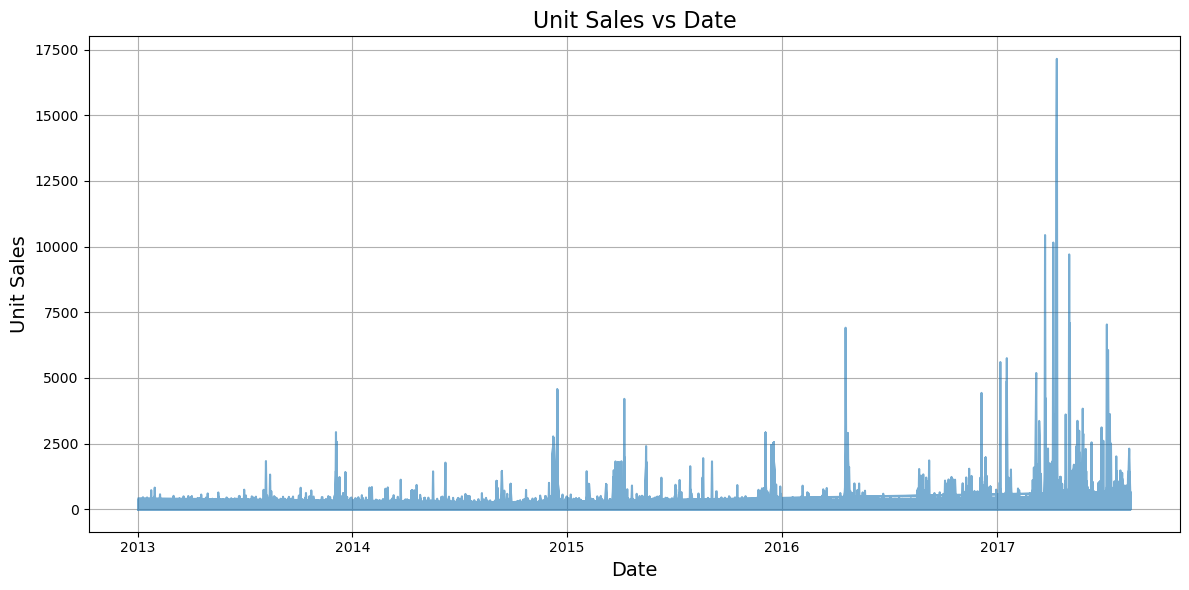

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier
0,24,105574,2013-01-02,18790.0,12.0,0,0
1,24,105574,2013-01-03,59692.0,1.0,0,0
2,24,105574,2013-01-04,99664.0,3.0,0,0
3,24,105574,2013-01-05,140805.0,4.0,0,0
4,24,105574,2013-01-06,182800.0,7.0,0,0


In [ ]:
# Visualize total unit_sales vs date

plt.figure(figsize=(12, 6))
plt.plot(df_full['date'], df_full['unit_sales'], alpha=0.6)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Unit Sales', fontsize=14)
plt.title('Unit Sales vs Date', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
df_full.head(5)

## Adding External Features

Oil Prices (dcoilwtico): Fetched from an external dataset, missing values filled using linear interpolation.

Transactions (transactions): Represents customer traffic, missing values filled with 0.

Holiday & Event Flags (is_holiday, is_event): Regional indicators merged based on date, duplicates resolved.

In [23]:
#Add Oil Prices (Feature Engineering)
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_full['date'] = pd.to_datetime(df_full['date'])

#df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear', limit_direction='both')
df_full = df_full.merge(df_oil, on='date', how='left')
df_full.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico
0,24,105574,2013-01-02,18790.0,12.0,0,0,93.14
1,24,105574,2013-01-03,59692.0,1.0,0,0,92.97
2,24,105574,2013-01-04,99664.0,3.0,0,0,93.12
3,24,105574,2013-01-05,140805.0,4.0,0,0,NaN
4,24,105574,2013-01-06,182800.0,7.0,0,0,NaN


In [78]:
#Add Store Transactions (Feature Engineering)

#Filtered stores located in the Guayas state
df_store_Guayas= df_stores[df_stores['state']=='Guayas']
print('Store shape is ', df_store_Guayas.shape)

#Extracted store numbers (store_nbr) for use in downstream tasks like sales or location-based filtering
store_nbr_list_guayas = df_store_Guayas['store_nbr'].tolist()
print('store number in Guayas\n',store_nbr_list_guayas)
store_nbr_list_guayas

#Filter transactions for stores in Guayas
df_transactions_guayas = df_transactions[df_transactions['store_nbr'].isin(store_nbr_list_guayas)]
df_transactions_guayas['date'] = pd.to_datetime(df_transactions_guayas['date'])
df_transactions_guayas


df_transactions_guayas['date'] = pd.to_datetime(df_transactions_guayas['date'])
df_full = df_full.merge(df_transactions_guayas, on=['store_nbr', 'date'], how='left')

df_full['transactions'] = df_full['transactions'].fillna(0).astype(int)
df_full.head()

Store shape is  (11, 5)
store number in Guayas
 [24, 26, 27, 28, 29, 30, 32, 34, 35, 36, 51]


/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_2501/2250081479.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transactions_guayas['date'] = pd.to_datetime(df_transactions_guayas['date'])
/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_2501/2250081479.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transactions_guayas['date'] = pd.to_datetime(df_transactions_guayas['date'])


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,transactions
0,24,105574,2013-01-02,18790.0,12.0,0,0,2605
1,24,105574,2013-01-03,59692.0,1.0,0,0,2462
2,24,105574,2013-01-04,99664.0,3.0,0,0,2607
3,24,105574,2013-01-05,140805.0,4.0,0,0,2578
4,24,105574,2013-01-06,182800.0,7.0,0,0,2061


In [84]:
# Filter holiday data to include only relevant cities in Guayas.
filtered_holidays_guayas = df_holidays_events[
    df_holidays_events['locale_name'].isin(['Guayaquil', 'Daule', 'Playas', 'Libertad'])
]

#Add Holiday and Event Flags (Feature Engineering)
filtered_holidays_guayas['date'] = pd.to_datetime(filtered_holidays_guayas['date'])

print('The filtered_holidays_guayas shape is',filtered_holidays_guayas.shape)
print('the unique dates are',len(filtered_holidays_guayas['date'].unique()))

# Find dates that appear more than once
duplicate_dates = filtered_holidays_guayas['date'].value_counts()
duplicate_dates = duplicate_dates[duplicate_dates > 1].index
duplicate_dates

# Filter the dataset for those dates
filtered_holidays_guayas_duplicates = filtered_holidays_guayas[filtered_holidays_guayas['date'].isin(duplicate_dates)]
filtered_holidays_guayas_duplicates


The filtered_holidays_guayas shape is (17, 8)
the unique dates are 16


/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_2501/547115798.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_holidays_guayas['date'] = pd.to_datetime(filtered_holidays_guayas['date'])


,date,type,locale,locale_name,description,transferred,is_holiday,is_event
264,2016-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False,1,0
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False,1,0


We are working with a holiday dataset where some dates might have duplicate rows or conflicting data. The goal is to clean it so there's only one row per date, and if there's any disagreement (e.g. one row says it's a holiday and another says it's not), you treat it as a holiday.

In [ ]:
# Resolve duplicates in holiday dataset

# Create an empty list to store cleaned rows
cleaned_rows = []

# Groups the dataset so that all rows with the same date are in the same grou.
grouped = filtered_holidays_guayas.groupby('date')

# Loop through each group of rows for the same date
for date, group in grouped:
    row = group.iloc[0].copy()

    if group['is_holiday'].nunique() > 1:
        # If there are different values for 'is_holiday', set both to 1
        row['is_holiday'] = 1
        row['is_event'] = 1

    cleaned_rows.append(row)

# Create a new DataFrame from the cleaned rows
filtered_holidays_guayas_corrected = pd.DataFrame(cleaned_rows)
print('Unique dates ',filtered_holidays_guayas_corrected['date'].nunique())
filtered_holidays_guayas_corrected.head()

Unique dates  16


,date,type,locale,locale_name,description,transferred,is_holiday,is_event
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0
49,2013-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0
64,2013-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False,1,0
65,2013-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,False,1,0
98,2014-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0


In [86]:
holidays_guayas=filtered_holidays_guayas_corrected[['date', 'is_holiday', 'is_event']]
holidays_guayas

,date,is_holiday,is_event
3,2012-04-14,1,0
49,2013-04-14,1,0
64,2013-07-24,1,0
65,2013-07-25,1,0
98,2014-04-14,1,0
127,2014-07-24,1,0
128,2014-07-25,1,0
168,2015-04-14,1,0
182,2015-07-24,1,0
183,2015-07-25,1,0


### Merge with main data

In [87]:
# Merge with main data
df_full = df_full.merge(holidays_guayas, on='date', how='left')

# Fill NaN values in 'is_holiday' and 'is_event' columns with 0
df_full['is_holiday'] = df_full['is_holiday'].fillna(0).astype(int)
df_full['is_event'] = df_full['is_event'].fillna(0).astype(int)

In [30]:
# Now we have all dates and corresponding sales for them. Let's replace the original dataframe.
df_train = df_full
del df_full

# Save combined data for further feature engineering

In [ ]:
#df_tain.to_csv('full_merged_data.csv', index= False
#from google.colab import files
#files.download('full_merged_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
#Save the CSV
df_train.to_csv('Data/train_Guayas_processed.csv', index=False)
#Read data automatically from drive
df_train = pd.read_csv('Data/train_Guayas_processed.csv')


In [34]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,is_event
0,24,105574,2013-01-02,18790.0,12.0,0,0,93.14,2605,0,0
1,24,105574,2013-01-03,59692.0,1.0,0,0,92.97,2462,0,0
2,24,105574,2013-01-04,99664.0,3.0,0,0,93.12,2607,0,0
3,24,105574,2013-01-05,140805.0,4.0,0,0,NaN,2578,0,0
4,24,105574,2013-01-06,182800.0,7.0,0,0,NaN,2061,0,0


Summary of Columns Get in Final Data:

- store_nbr, item_nbr, date, unit_sales(zero-filled), onpromotion (binary flag), outlier (binary flag for high sales (1 if sales are extreme)), dcoilwtico (oil price), transactions (store traffic), is_holiday, is_event

In [35]:
df_train.shape

(35069356, 11)